In [25]:
import numpy as np
import pandas as pd
import os

## for initial analysis
from funcs.scraper import CollectComments
from funcs.initial_analysis import pie_chart, histo, word_cloud, word_frequency_counter

## for processing wiki database
from funcs.utils import cleantext, file_path_name_generator
from funcs.wiki_cn_handler import convert_wiki_cn, seperate_sentence, MySentences

## for word2vec training
from gensim.models import Word2Vec
import multiprocessing
from gensim.models import Phrases
from gensim.models import KeyedVectors

## for training data prep
from funcs.training_data_preparing import get_training_data

## for LSTM model
from keras.utils import pad_sequences
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# 豆瓣三体动画短评分析
## Douban review analysis

This project provided the analysis of the short comments of **The Three-Body Problem Animation**

Useful functions are in the **funcs** package, including scraper, initial_analysis, chinese_converting, w2v_model_training, sentiment_analysis

## Part I: Scrape and store

In [3]:
## cookie need to be updated manually because of the new login requirement of Douban
COOKIE = 'push_doumail_num=0; push_noty_num=0; _vwo_uuid_v2=DAAEF2DB6070490F44837287B7D3D797C|75b8cb11e0d9a6bbf28b5ee9b67a20a8; __utma=30149280.526420392.1673120562.1673120562.1673480474.2; __utmb=30149280.29.10.1673480474; __utmc=30149280; __utmv=30149280.2597; __utmz=30149280.1673120562.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utma=223695111.488996994.1673480474.1673480474.1673480474.1; __utmb=223695111.0.10.1673480474; __utmc=223695111; __utmz=223695111.1673480474.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); _pk_id.100001.4cf6=3941380d5373def8.1673480474.1.1673481310.1673480474.; _pk_ses.100001.4cf6=*; __utmt=1; __utmt_douban=1; frodotk_db="be0943d1a2339aaa3a1bcb74e69acffe"; ap_v=0,6.0; ck=7eSj; dbcl2="25977271:W1EkFloTu78"; ll="108258"; bid=rX6WylNFHYI'
FILE_PATH = 'comment_data.csv'

In [4]:
cc = CollectComments(cookie=COOKIE, file_path=FILE_PATH)

In [ ]:
cc.run()

## Part II: Basic analysis

In [15]:
## upload scraped data
df_comm = pd.read_csv('comment_data_local.csv')
df_no_dup = df_comm.drop_duplicates(subset=df_comm.columns.difference(['source']))
mask = df_no_dup['star'].apply(lambda x: x.isnumeric())
dataset_comm = df_no_dup[mask].copy()[['star', 'comment']].reset_index(drop=True)

In [24]:
## prepare stopword 
## using the hit_stopword from 
stopword_folder_path = '/Users/yingzhang/Documents/projects/stopwords-master'
stopword_file_path = stopword_folder_path + '/' + 'hit_stopwords.txt'

stopword = []
with open(stopword_file_path, 'r') as f:
    reader = f.read()
    for i in reader:
        if i != '\n':
            stopword.append(i)
            
sw_list = ['这个', '一个', '不少', '起来', '没有', '就是', '不是', '那个', '还是', '剧情', '这样', '那样', '这种', '那种', '故事', '人物', '什么', '这么', '那么', '真的']

In [25]:
## get word count 
word_freq = word_frequency_counter(dataset_comm, stopword=stopword+sw_list)

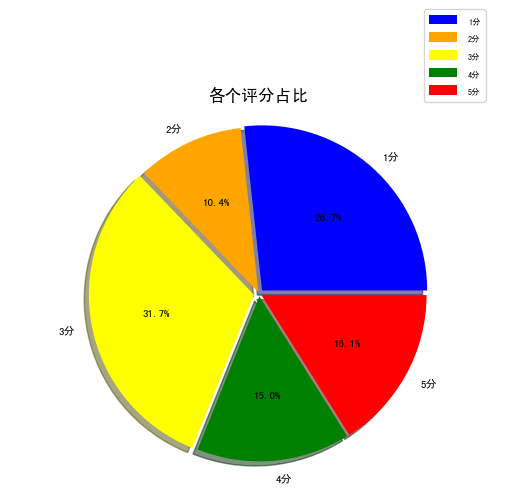

In [26]:
## pie_chart
pie_chart(dataset_comm)

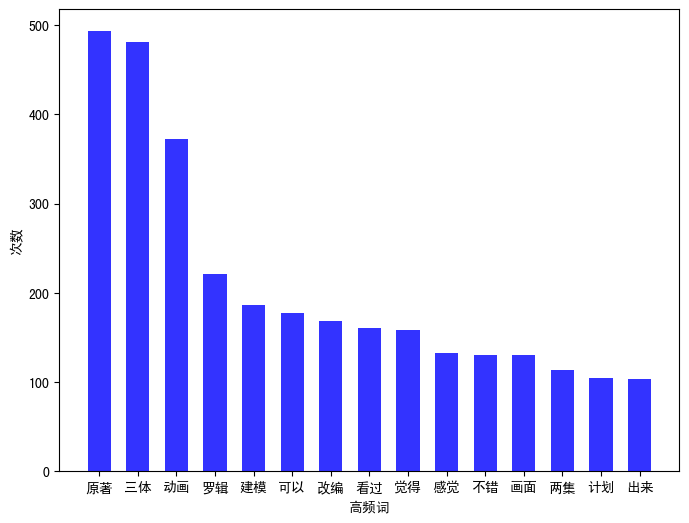

In [27]:
## histo about high frequency words
histo(word_freq)

In [29]:
import jieba

In [30]:
seg = jieba.cut('不可以这样做')

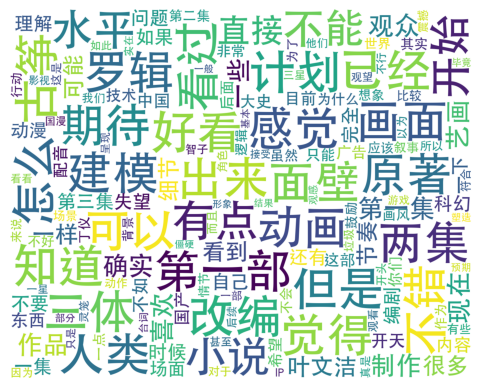

In [28]:
# get word cloud
word_cloud(word_freq)

## Part II: Sentitment analysis

In order to achieve a better accuracy, Word2Vec model is utilized for embedding the short comments. So there are two steps to complete: 
 * Word2Vec model training using chinese wiki database backup
 * Sentiment analysis on starred comments using LSTM model
 * Prediction of the unstarred comments and calculat the final score

### 1. Training of Word2Vec model

In [6]:
TEXT_DIR = '/Users/yingzhang/Documents/projects/dataset/wiki_cn_text/'
SIMPLIFIED_DIR = '/Users/yingzhang/Documents/projects/dataset/wiki_cn_text_simplified/'
SEPERATED_DIR = '/Users/yingzhang/Documents/projects/dataset/wiki_cn_text_seperated/'

In [ ]:
## prepare the simplifed chinese wiki database
convert_wiki_cn(TEXT_DIR, SIMPLIFIED_DIR)
## prepare the training tokenized database
seperate_sentence(SIMPLIFIED_DIR, SEPERATED_DIR)
## prepare the sentence for Word2Vec model training
sentence = MySentences(SEPERATED_DIR)

In [10]:
model = Word2Vec(sentence,
                vector_size=200,
                window=10,
                min_count=10,
                workers=multiprocessing.cpu_count())

In [11]:
os.mkdir('embedding_model/')
model.save("embedding_model/word2vec_gensim")
model.wv.save_word2vec_format("embedding_model/word2vec_org",
                                  "embedding_model/vocabulary",
                                  binary=False)

### 2. LSTM model for starred comments

In [21]:
## loading embedding model
embedding_model = Word2Vec.load("embedding_model/word2vec_gensim")

In [22]:
tryX, tryY = get_training_data(dataset_comm, embedding_model)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/pp/zqcpgy9519n3pv2zd3tbtbhr0000gn/T/jieba.cache
Loading model cost 0.325 seconds.
Prefix dict has been built successfully.


已处理:百分之0.0
已处理:百分之10.0
已处理:百分之20.0
已处理:百分之30.0
已处理:百分之40.0
已处理:百分之50.0
已处理:百分之60.0
已处理:百分之70.0
已处理:百分之80.0
已处理:百分之90.0


In [23]:
len_words_paded = pad_sequences(tryX, padding='post', dtype='float')
tag_arr = np.array(tryY)

In [28]:
np.shape(len_words_paded)

(2010, 200, 200)

In [29]:
np.shape(tag_arr)

(2010,)

In [31]:
model = Sequential()
model.add(LSTM(256, dropout=.5, recurrent_dropout=.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
es = EarlyStopping(
              monitor='val_loss', 
              patience=3, 
              min_delta=0.001)

In [2]:
2010/64

31.40625

In [32]:
model.fit(len_words_paded, tag_arr, 
          epochs=5, 
          batch_size=64,
          validation_split=0.1,
          
          callbacks=[es]
          )

Epoch 1/5
29/29 [==============================] - 35s 1s/step - loss: 1.0894 - accuracy: 0.4102 - val_loss: 1.1689 - val_accuracy: 0.0149
Epoch 2/5
29/29 [==============================] - 35s 1s/step - loss: 1.0859 - accuracy: 0.4118 - val_loss: 1.1749 - val_accuracy: 0.0149
Epoch 3/5
29/29 [==============================] - 36s 1s/step - loss: 1.0854 - accuracy: 0.4118 - val_loss: 1.2194 - val_accuracy: 0.0149
Epoch 4/5
29/29 [==============================] - 36s 1s/step - loss: 1.0848 - accuracy: 0.4118 - val_loss: 1.2042 - val_accuracy: 0.0149
